In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle  # Optional, to save the feature vectors if needed
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


In [3]:
# Install pdfplumber
!pip install pdfplumber

import pdfplumber
import os

def extract_text_pdfplumber(pdf_path):
    try:
        text = ""
        with pdfplumber.open(pdf_path) as pdf:
            for page in pdf.pages:
                text += page.extract_text() + "\n"
        return text
    except Exception as e:
        print(f"Error reading {pdf_path}: {e}")
        return None

# Specify directory with PDF files
pdf_directory = '/content/drive/MyDrive/Ego/Resumes'
text_output_directory = '/content/drive/MyDrive/Ego/TextFiles_pdfplumber'
os.makedirs(text_output_directory, exist_ok=True)

# Extract text from each PDF and save it to a text file
for pdf_file in os.listdir(pdf_directory):
    if pdf_file.endswith('.pdf'):
        pdf_path = os.path.join(pdf_directory, pdf_file)
        text = extract_text_pdfplumber(pdf_path)
        if text:
            text_file_path = os.path.join(text_output_directory, pdf_file.replace('.pdf', '.txt'))
            with open(text_file_path, 'w', encoding='utf-8') as f:
                f.write(text)
            print(f"Text extracted and saved for {pdf_file}")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 32.0 MB/s eta 0:00:00
Text extracted and saved for Resume_4.pdf
Text extracted and saved for Resume_9.pdf
Text extracted and saved for Resume_7.pdf
Text extracted and saved for Resume_3.pdf
Text extracted and saved for Resume_11.pdf
Text extracted and saved for Resume_1.pdf
Text extracted and saved for Resume_2.pdf
Text extracted and saved for Resume_8.pdf
Text extracted and saved for Resume_13.pdf
Text extracted and saved for Resume_12.pdf
Text extracted and saved for Resume_10.pdf
Text extracted and saved for Resume_14.pdf
Text extracted and saved for Resume_6.pdf
Text extracted and saved for Resume_5.pdf
Text extracted 

In [4]:
preprocessed_directory = '/content/drive/MyDrive/Ego/Preprocess_pdfplumber'
os.makedirs(text_output_directory, exist_ok=True)

In [5]:
# Download stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [6]:
# Preprocessing function to clean and tokenize text
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenize text
    words = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    # Join words back into a single string
    return ' '.join(words)

In [7]:
# Iterate through PDF files in the specified directory
for pdf_file in os.listdir(pdf_directory):
    if pdf_file.endswith('.pdf'):
        pdf_path = os.path.join(pdf_directory, pdf_file)
        text = extract_text_pdfplumber(pdf_path)

        # If text extraction was successful, preprocess it and save
        if text:
            # Save original extracted text
            output_file = os.path.join(text_output_directory, pdf_file.replace('.pdf', '.txt'))
            with open(output_file, 'w', encoding='utf-8') as f:
                f.write(text)

            # Preprocess and save preprocessed text
            preprocessed_text = preprocess_text(text)
            preprocessed_file = os.path.join(preprocessed_directory, pdf_file.replace('.pdf', '_preprocessed.txt'))

            # Create the directory if it doesn't exist
            os.makedirs(os.path.dirname(preprocessed_file), exist_ok=True)

            with open(preprocessed_file, 'w', encoding='utf-8') as f:
                f.write(preprocessed_text)

            print(f"Processed and saved text from {pdf_file}")

Processed and saved text from Resume_4.pdf
Processed and saved text from Resume_9.pdf
Processed and saved text from Resume_7.pdf
Processed and saved text from Resume_3.pdf
Processed and saved text from Resume_11.pdf
Processed and saved text from Resume_1.pdf
Processed and saved text from Resume_2.pdf
Processed and saved text from Resume_8.pdf
Processed and saved text from Resume_13.pdf
Processed and saved text from Resume_12.pdf
Processed and saved text from Resume_10.pdf
Processed and saved text from Resume_14.pdf
Processed and saved text from Resume_6.pdf
Processed and saved text from Resume_5.pdf
Processed and saved text from updated_resume.pdf


In [8]:

# Read preprocessed text files and store their content in a list
documents = []
filenames = []

for file in os.listdir(preprocessed_directory):
    if file.endswith('_preprocessed.txt'):
        file_path = os.path.join(preprocessed_directory, file)
        with open(file_path, 'r', encoding='utf-8') as f:
            text = f.read()
            documents.append(text)
            filenames.append(file)  # Optional: Keep track of file names


In [9]:
# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))  # Including bigrams
  # Adjust max_features as needed

# Transform documents into TF-IDF feature vectors
tfidf_matrix = tfidf_vectorizer.fit_transform(documents)

# Convert the TF-IDF matrix to an array for easier handling
feature_vectors = tfidf_matrix.toarray()

# Optional: Save feature vectors and filenames for future use
with open('/content/drive/MyDrive/Ego/Vectorize', 'wb') as f:
    pickle.dump((filenames, feature_vectors), f)

with open('/content/drive/MyDrive/Ego/Vectorize', 'rb') as f:
  filenames, feature_vectors = pickle.load(f)

print("Feature vectors created successfully!")

Feature vectors created successfully!


In [10]:
print("Loaded feature vectors for documents:", filenames)
print("Shape of feature vectors matrix:", feature_vectors.shape)

Loaded feature vectors for documents: ['Resume_4_preprocessed.txt', 'Resume_9_preprocessed.txt', 'Resume_7_preprocessed.txt', 'Resume_3_preprocessed.txt', 'Resume_11_preprocessed.txt', 'Resume_1_preprocessed.txt', 'Resume_2_preprocessed.txt', 'Resume_8_preprocessed.txt', 'Resume_13_preprocessed.txt', 'Resume_10_preprocessed.txt', 'Resume_12_preprocessed.txt', 'Resume_14_preprocessed.txt', 'Resume_6_preprocessed.txt', 'Resume_5_preprocessed.txt', 'updated_resume_preprocessed.txt']
Shape of feature vectors matrix: (15, 5000)


In [11]:
import pandas as pd
# Load ego-related keywords and their categories from the drive
keywords_path = '/content/drive/MyDrive/Ego/Words_score_ego.csv'
keywords_df = pd.read_csv(keywords_path)

# Display the loaded keywords
print(keywords_df.head())

                                Keywordord Category
0                             Accomplished     High
1  Achieved all targets ahead of deadlines     High
2       Achieved highest sales in the team     High
3      Achieved project milestones on time     High
4                                Assertive     High


In [12]:
# Convert keywords into a single text document for each category
keywords_text = keywords_df.groupby('Category')['Keywordord'].apply(lambda x: ' '.join(x)).to_dict()

# Vectorize keywords by category using TF-IDF
vectorizer = TfidfVectorizer()
keywords_matrix = vectorizer.fit_transform(keywords_text.values())
keywords_labels = list(keywords_text.keys())

print("Keywords Feature Matrix Shape:", keywords_matrix.shape)


Keywords Feature Matrix Shape: (3, 242)


In [13]:
# Path to the folder where resume text files are stored
resume_folder_path = '/content/drive/MyDrive/Ego/TextFiles_pdfplumber'

# List all text files in the folder
resume_files = [f for f in os.listdir(resume_folder_path) if f.endswith('.txt')]

# Read the contents of each resume file and store them in a list
resume_texts = []

for file_name in resume_files:
    file_path = os.path.join(resume_folder_path, file_name)
    with open(file_path, 'r', encoding='utf-8') as file:
        resume_texts.append(file.read())

# Now, `resume_texts` contains the text of all resumes
print(f"Loaded {len(resume_texts)} resumes.")


Loaded 15 resumes.


In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Combine both resume texts and keywords into one list for vectorization
all_texts = resume_texts + list(keywords_text.values())  # All resume texts and keyword texts

# Fit the TF-IDF vectorizer on both resume and keyword data
vectorizer = TfidfVectorizer()
combined_matrix = vectorizer.fit_transform(all_texts)

# Separate the combined matrix back into resume_matrix and keywords_matrix
resume_matrix = combined_matrix[:len(resume_texts), :]  # First part corresponds to resumes
keywords_matrix = combined_matrix[len(resume_texts):, :]  # Remaining part corresponds to keywords


In [15]:
from sklearn.preprocessing import normalize
import pandas as pd
from sklearn.metrics.pairwise import manhattan_distances

# Normalize the resume and keyword matrices
resume_matrix_normalized = normalize(resume_matrix, norm='l1')
keywords_matrix_normalized = normalize(keywords_matrix, norm='l1')

# Compute Manhattan Distance between normalized resumes and keywords
manhattan_dist = manhattan_distances(resume_matrix_normalized, keywords_matrix_normalized)

# Convert distances to DataFrame
manhattan_df = pd.DataFrame(manhattan_dist, columns=keywords_labels)

# Output the similarity scores
print(manhattan_df)


        High       Low  Moderate
0   1.854427  1.908642  1.859636
1   1.897991  1.894101  1.874821
2   1.858174  1.884438  1.862381
3   1.878456  1.879590  1.852158
4   1.870518  1.908881  1.873200
5   1.822518  1.832182  1.847267
6   1.885024  1.863753  1.865045
7   1.805973  1.870472  1.813465
8   1.965501  1.977223  1.962953
9   1.904627  1.924704  1.907765
10  1.856839  1.864300  1.842696
11  1.847795  1.863958  1.871246
12  1.911494  1.926888  1.857524
13  1.890416  1.882240  1.840548
14  1.858364  1.838985  1.855936


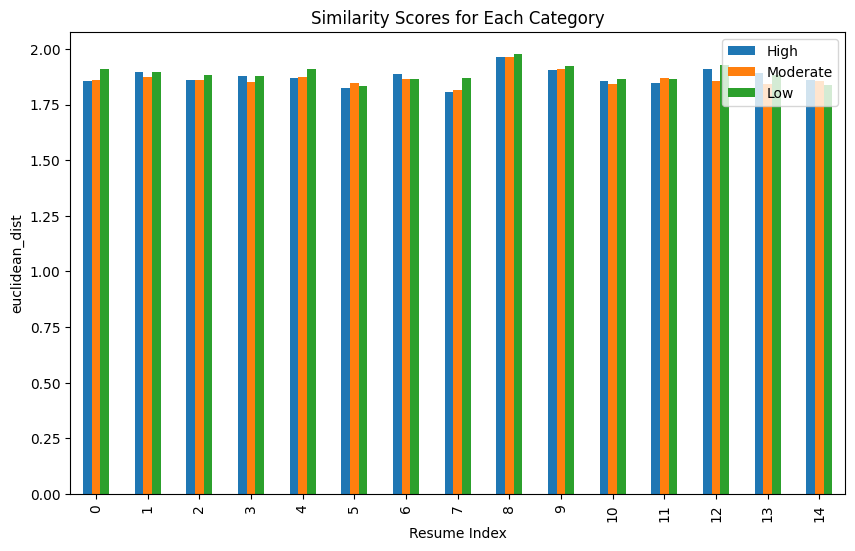

In [16]:
import matplotlib.pyplot as plt

# Plot similarity scores for each category
manhattan_df[['High','Moderate', 'Low']].plot(kind='bar', figsize=(10, 6))
plt.title('Similarity Scores for Each Category')
plt.ylabel('euclidean_dist')
plt.xlabel('Resume Index')
plt.show()


In [17]:
print("Resume Matrix shape:", resume_matrix.shape)
print("Keywords Matrix shape:", keywords_matrix.shape)


Resume Matrix shape: (15, 2344)
Keywords Matrix shape: (3, 2344)


In [18]:
print("Combined Matrix shape:", combined_matrix.shape)


Combined Matrix shape: (18, 2344)


In [19]:
#This True_labels for the small amount of resumes that can be manually labels
# Define true labels for each resume
# These labels should match the order of the resumes in `resume_texts`
true_labels = ['Moderate', 'Moderate', 'Moderate', 'Moderate', 'Low', 'High', 'Moderate', 'Low', 'High', 'High', 'Moderate', 'Moderate', 'Moderate', 'Moderate', 'High']  # Replace with actual labels


Summary of distances:
            High        Low   Moderate
count  15.000000  15.000000  15.000000
mean    1.873874   1.888024   1.865776
std     0.038593   0.037215   0.033829
min     1.805973   1.832182   1.813465
25%     1.855633   1.864129   1.849713
50%     1.870518   1.882240   1.859636
75%     1.894204   1.908762   1.872223
max     1.965501   1.977223   1.962953


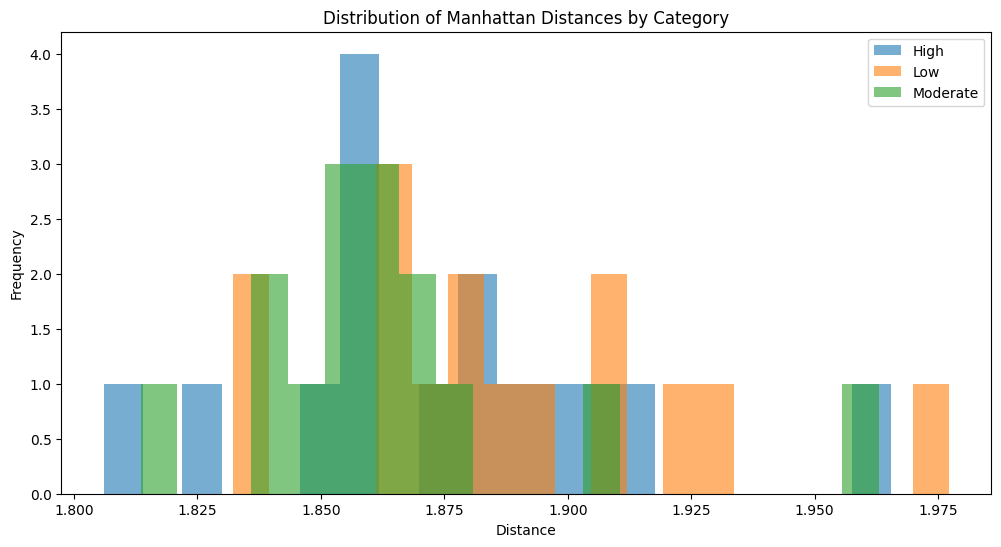

Low Threshold (High Category): 1.8576666587999406
Medium Threshold (Moderate Category): 1.866532794868742
Labeled DataFrame:
        High  Moderate       Low Predicted_Label
0   1.854427  1.859636  1.908642            High
1   1.897991  1.874821  1.894101             Low
2   1.858174  1.862381  1.884438        Moderate
3   1.878456  1.852158  1.879590        Moderate
4   1.870518  1.873200  1.908881             Low
5   1.822518  1.847267  1.832182            High
6   1.885024  1.865045  1.863753        Moderate
7   1.805973  1.813465  1.870472            High
8   1.965501  1.962953  1.977223             Low
9   1.904627  1.907765  1.924704             Low
10  1.856839  1.842696  1.864300            High
11  1.847795  1.871246  1.863958            High
12  1.911494  1.857524  1.926888        Moderate
13  1.890416  1.840548  1.882240        Moderate
14  1.858364  1.855936  1.838985        Moderate
Labeled resumes saved to Labeled_Resumes.csv.


In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Compute Manhattan distances
# manhattan_dist is a DataFrame where rows are resumes and columns are categories (High, Moderate, Low)
manhattan_dist = pd.DataFrame(manhattan_distances(resume_matrix_normalized, keywords_matrix_normalized),
                              columns=keywords_labels)

# Analyze the Manhattan distances
print("Summary of distances:")
print(manhattan_dist.describe())

# Visualize distances for each category
plt.figure(figsize=(12, 6))
for category in keywords_labels:
    plt.hist(manhattan_dist[category], bins=20, alpha=0.6, label=category)
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.title("Distribution of Manhattan Distances by Category")
plt.legend()
plt.show()

# Define thresholds dynamically based on percentiles
# For example: Use the 33rd percentile for Low, and 66th percentile for High
low_threshold = np.percentile(manhattan_dist['High'], 33)   # Threshold for High to Medium
medium_threshold = np.percentile(manhattan_dist['Moderate'], 66)  # Threshold for Medium to Low

print(f"Low Threshold (High Category): {low_threshold}")
print(f"Medium Threshold (Moderate Category): {medium_threshold}")

# Function to label resumes based on thresholds
def label_with_dynamic_threshold(row):
    if row["High"] <= low_threshold:
        return "High"
    elif row["Moderate"] <= medium_threshold:
        return "Moderate"
    else:
        return "Low"

# Apply the labeling function to the Manhattan distance DataFrame
manhattan_dist['Predicted_Label'] = manhattan_dist.apply(label_with_dynamic_threshold, axis=1)

# Display the results
print("Labeled DataFrame:")
print(manhattan_dist[['High', 'Moderate', 'Low', 'Predicted_Label']])

# Save labeled results for further analysis
manhattan_dist.to_csv('/content/drive/MyDrive/Ego/Labeled_Resumes.csv', index=False)
print("Labeled resumes saved to Labeled_Resumes.csv.")


In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

# Check columns in the DataFrame to ensure it only has the expected feature columns
print("Columns in manhattan_df:", manhattan_df.columns)

# Use the similarity scores as features
X = manhattan_df  # Use the DataFrame directly if it only has the similarity score columns
y = true_labels    # True labels for each resume as previously defined

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the RandomForest classifier
classifier = RandomForestClassifier(n_estimators=50, random_state=42)
classifier.fit(X_train, y_train)

# Predict labels for the testing data
y_pred_test = classifier.predict(X_test)

# Evaluate and display results for the testing data
print("Testing Data Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_test))

# Fixed target names for classification report and confusion matrix
fixed_categories = ["High", "Moderate", "Low"]




Columns in manhattan_df: Index(['High', 'Low', 'Moderate'], dtype='object')
Testing Data Results:
Accuracy: 0.6666666666666666


In [22]:
# Ensure classifier predictions include probabilities
y_pred_all = classifier.predict(X)
y_pred_probs = classifier.predict_proba(X)

# Assign weights for High, Moderate, and Low
weights = {'High': 3, 'Moderate': 2, 'Low': 1}

# Calculate weighted scores for each resume
overall_scores = []
for probs in y_pred_probs:
    weighted_score = sum(p * weights[label] for p, label in zip(probs, classifier.classes_))
    normalized_score = (weighted_score / max(weights.values())) * 100  # Normalize to 100
    overall_scores.append(normalized_score)

# Map predicted labels to their corresponding overall scores
predictions_df = pd.DataFrame({
    'Resume': manhattan_df.index,
    'Predicted Label': y_pred_all,
    'Overall Score': [round(score, 2) for score in overall_scores]  # Round scores to 2 decimals
})

# Display the predictions
print("\nPredictions DataFrame:")
print(predictions_df)

# Save predictions to a CSV file
predictions_df.to_csv('/content/drive/MyDrive/Ego/Predictions_Scored.csv', index=False)
print("Predictions saved to Predictions_Scored.csv.")



Predictions DataFrame:
    Resume Predicted Label  Overall Score
0        0        Moderate          58.67
1        1        Moderate          64.00
2        2        Moderate          65.33
3        3        Moderate          66.67
4        4             Low          43.33
5        5            High          86.67
6        6        Moderate          66.67
7        7             Low          46.67
8        8            High          91.33
9        9        Moderate          56.67
10      10        Moderate          66.67
11      11        Moderate          60.00
12      12        Moderate          64.00
13      13        Moderate          66.67
14      14            High          91.33
Predictions saved to Predictions_Scored.csv.


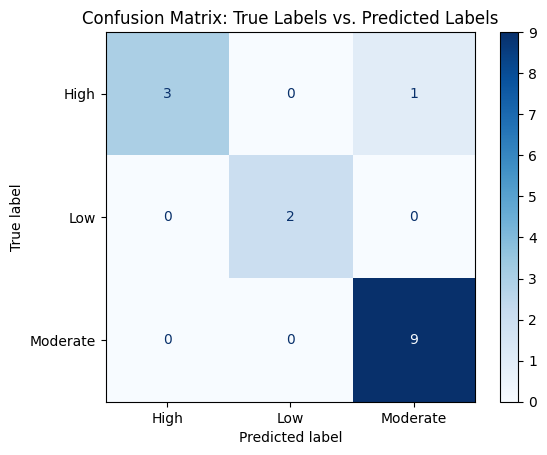


Confusion Matrix (as text):
[[3 0 1]
 [0 2 0]
 [0 0 9]]


In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate the confusion matrix using true labels and predicted labels
conf_matrix = confusion_matrix(y, y_pred_all, labels=classifier.classes_)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=classifier.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix: True Labels vs. Predicted Labels')
plt.show()

# Print the confusion matrix as text (optional)
print("\nConfusion Matrix (as text):")
print(conf_matrix)


In [29]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Initialize Grid Search
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5)

grid_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

# Use the best estimator from grid search for predictions
best_classifier = grid_search.best_estimator_
y_pred_best = best_classifier.predict(X_test)

# Evaluate performance of the best model
accuracy_best = accuracy_score(y_test, y_pred_best)
print("Optimized Accuracy:", accuracy_best)
print("Optimized Classification Report:")

# Get unique class labels from training data
unique_labels = sorted(set(y_train))

# Filter out labels not present in y_test
labels_in_test = [label for label in unique_labels if label in set(y_test)]

# Use filtered labels in the classification_report
print(classification_report(y_test, y_pred_best, target_names=labels_in_test))

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}
Optimized Accuracy: 0.6666666666666666
Optimized Classification Report:
              precision    recall  f1-score   support

        High       0.00      0.00      0.00         1
    Moderate       0.67      1.00      0.80         2

    accuracy                           0.67         3
   macro avg       0.33      0.50      0.40         3
weighted avg       0.44      0.67      0.53         3



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [25]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation
cv_scores = cross_val_score(classifier, X, y, cv=5, scoring='accuracy')
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean()}")


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Cross-validation scores: [0.66666667 0.66666667 1.         0.66666667 0.33333333]
Mean CV Accuracy: 0.6666666666666666
